In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error

# forecasting model
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import statsmodels.api as sm

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [19]:
train=pd.read_csv(r'C:\Users\tyagir01\Desktop\Train_SU63ISt.csv')
test=pd.read_csv(r'C:\Users\tyagir01\Desktop\Test_0qrQsBZ.csv')
sample_df=pd.read_csv(r'C:\Users\tyagir01\Desktop\Sample_submission_LSeus50.csv')

In [20]:
display(train.head())
display(test.head())
display(sample_df.head())

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0


In [21]:
## Creating the copies of original train and test datasets
train_original=train.copy()
test_original=test.copy()

In [22]:
print('Dataset Columns')
print(train.columns, '\n\n', test.columns)
print('-'*20)
print('Dtypes')
print(train.dtypes,'\n\n', test.dtypes)
print('-'*20)
print(train.shape, '\n\n', test.shape)


Dataset Columns
Index(['ID', 'Datetime', 'Count'], dtype='object') 

 Index(['ID', 'Datetime'], dtype='object')
--------------------
Dtypes
ID           int64
Datetime    object
Count        int64
dtype: object 

 ID           int64
Datetime    object
dtype: object
--------------------
(18288, 3) 

 (5112, 2)


In [23]:
# convert object to datetime data type
train['Datetime']=pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime']=pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
train_original['Datetime']=pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime']=pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M')

In [24]:
# extract datetime to year, month, day, hour
for i in (train, test, train_original, test_original):
  i['year']=i.Datetime.dt.year
  i['month']=i.Datetime.dt.month
  i['day']=i.Datetime.dt.day
  i['Hour']=i.Datetime.dt.hour

In [25]:
train.head()

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


In [26]:
test.head()

,ID,Datetime,year,month,day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


In [27]:
train_original.head()

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


In [28]:
test_original.head()

,ID,Datetime,year,month,day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


In [34]:
# convert test to daily mean
test.index=test.Datetime

In [35]:
# convert train to daily mean
train.index=train.Datetime

In [38]:
training = train[:16080]
valid = train[16080:]

In [51]:
valid.tail()

,ID,Datetime,Count,year,month,day,Hour
Datetime,,,,,,,
2014-09-25 19:00:00,18283,2014-09-25 19:00:00,868,2014,9,25,19
2014-09-25 20:00:00,18284,2014-09-25 20:00:00,732,2014,9,25,20
2014-09-25 21:00:00,18285,2014-09-25 21:00:00,702,2014,9,25,21
2014-09-25 22:00:00,18286,2014-09-25 22:00:00,580,2014,9,25,22
2014-09-25 23:00:00,18287,2014-09-25 23:00:00,534,2014,9,25,23


In [56]:
valid.shape

(2208, 7)

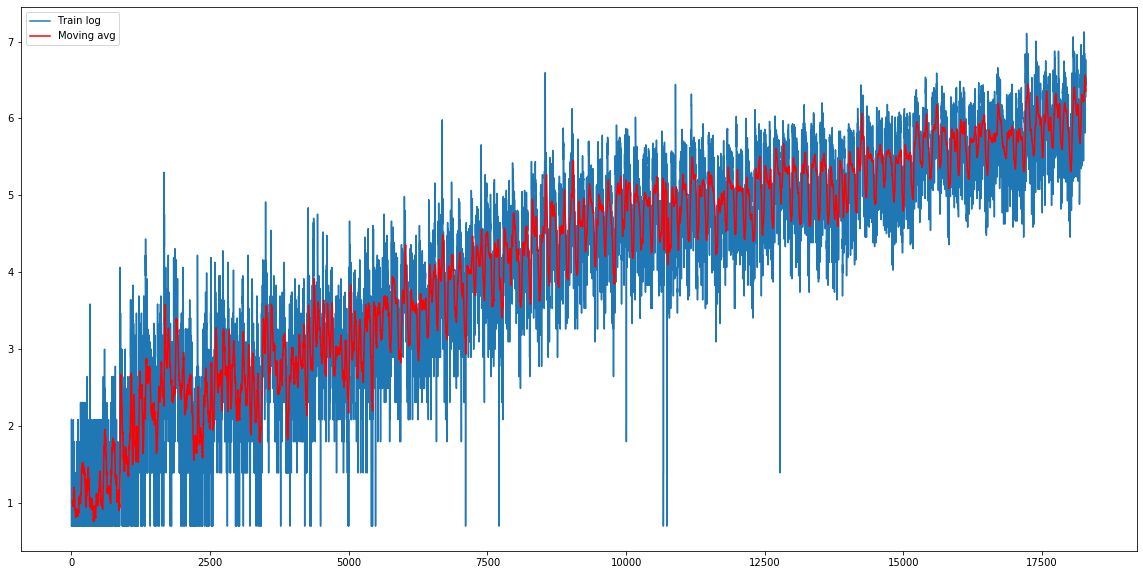

In [32]:
# to make more stationary, trend will be removed
Train_log = np.log(train['Count']) 
moving_avg = Train_log.rolling(24).mean()
plt.figure(figsize=(20,10))
plt.plot(Train_log, label='Train log') 
plt.plot(moving_avg, color = 'red', label='Moving avg') 
plt.legend(loc='best')

In [30]:
from statsmodels.tsa.stattools import adfuller 

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,10))  
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

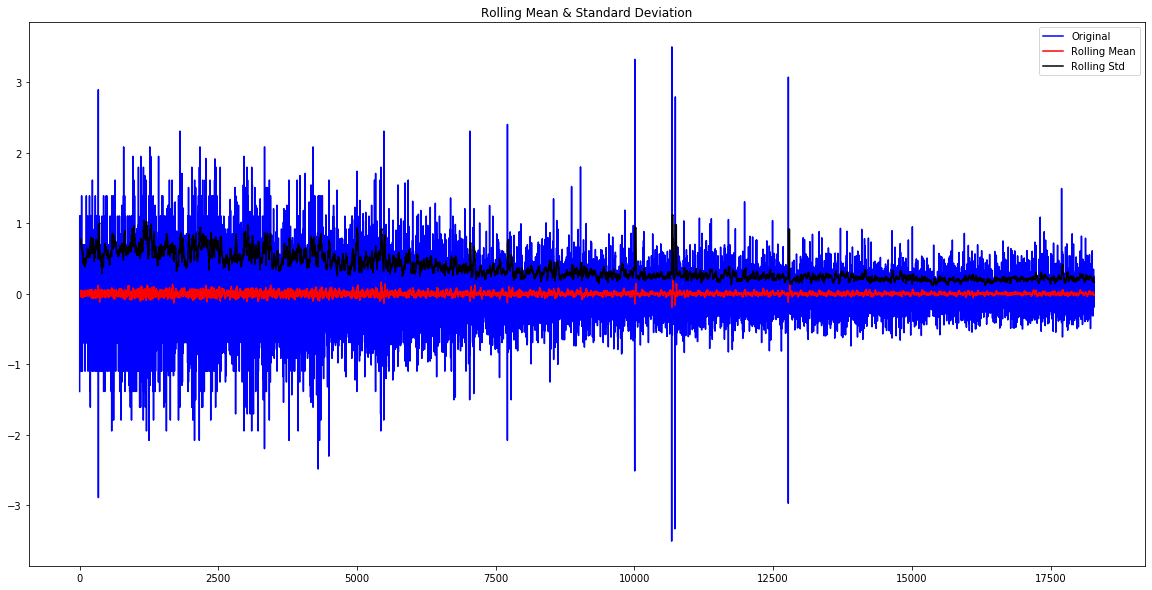

Results of Dickey-Fuller Test:
Test Statistic                   -32.041628
p-value                            0.000000
#Lags Used                        45.000000
Number of Observations Used    18241.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [33]:
train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

In [23]:
# forecats time series with ARIMA
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

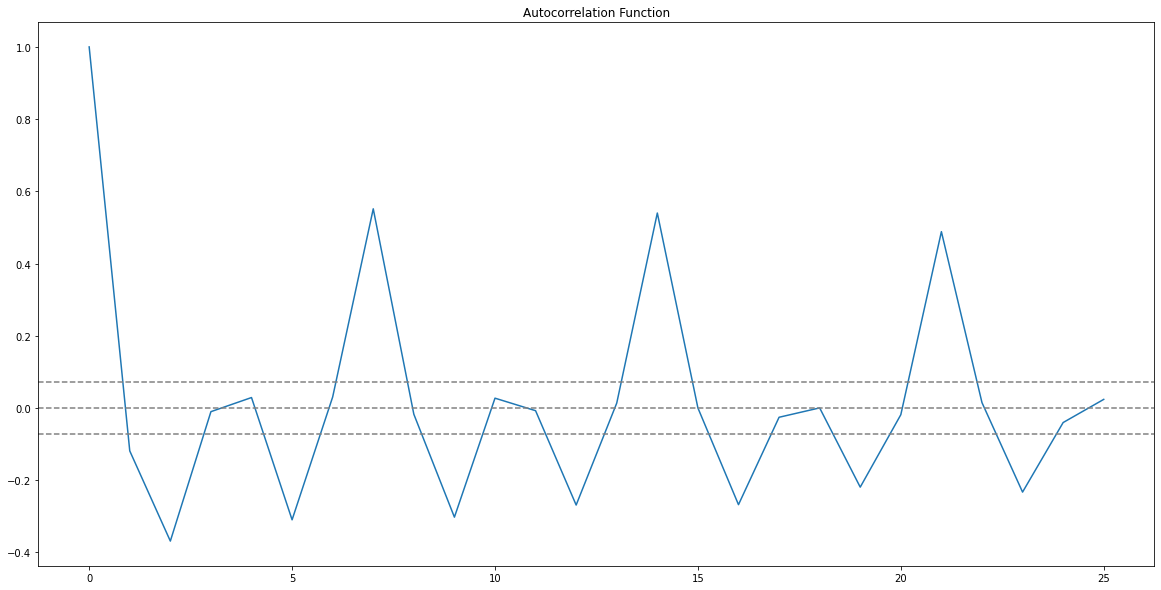

Text(0.5, 1.0, 'Partial Autocorrelation Function')

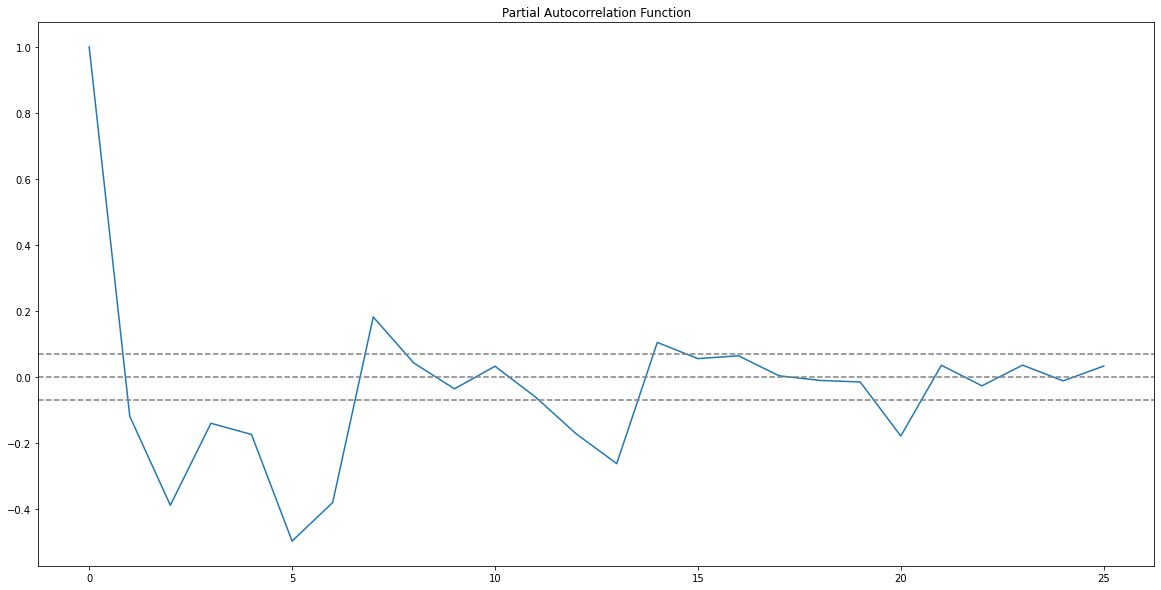

In [25]:
# ACF and PACF plot

plt.figure(figsize=(20,10))
plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Autocorrelation Function') 
plt.show()

plt.figure(figsize=(20,10))
plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray') 
plt.title('Partial Autocorrelation Function')

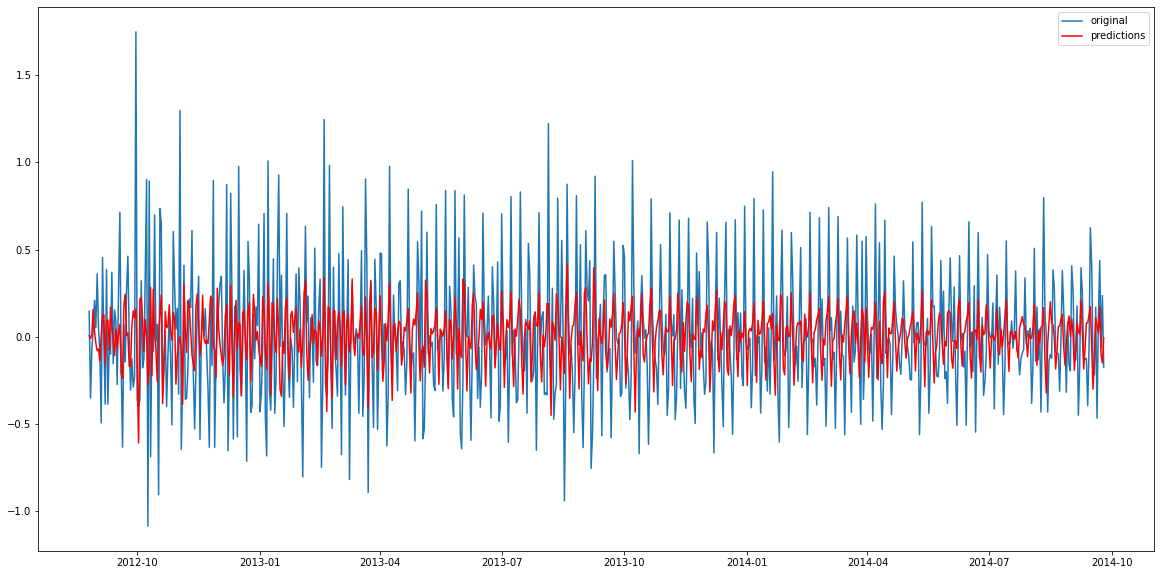

In [28]:
# AR model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1) 
plt.figure(figsize=(20,10)) 
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best')

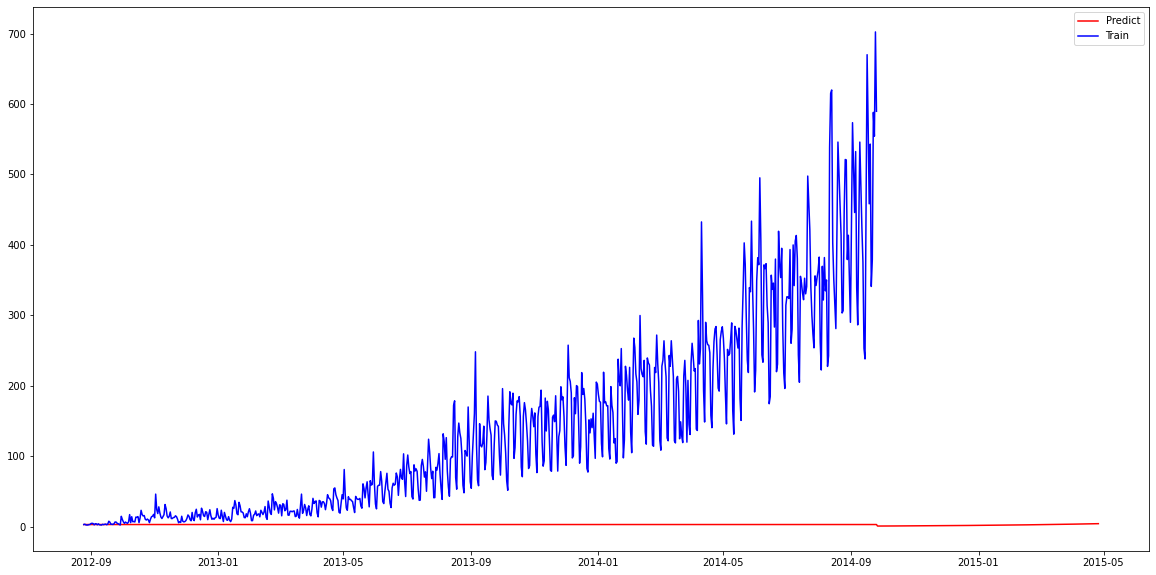

In [31]:
# test prediction curve for AR Model
AR_predict=results_AR.predict(start=test.index[0], end=test.index[-1]) 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(train.shape[0]) * np.log(train['Count'])[0], index = train.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
#plt.plot(test['Count'], label = "Valid") 
plt.figure(figsize=(20,10))
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.plot(train.Count, color='blue', label='Train')
plt.legend(loc= 'best') 
# plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, test['Count']))/valid.shape[0])) 
# plt.show()


In [37]:
dt=pd.date_range(start='2014-09-26', periods=len(test))
dt

DatetimeIndex(['2014-09-26', '2014-09-27', '2014-09-28', '2014-09-29',
               '2014-09-30', '2014-10-01', '2014-10-02', '2014-10-03',
               '2014-10-04', '2014-10-05',
               ...
               '2028-09-14', '2028-09-15', '2028-09-16', '2028-09-17',
               '2028-09-18', '2028-09-19', '2028-09-20', '2028-09-21',
               '2028-09-22', '2028-09-23'],
              dtype='datetime64[ns]', length=5112, freq='D')

In [59]:
model = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,24)).fit() 

In [60]:
pred = model.predict(start="2014-06-26 00:00:00", end="2014-09-25 23:00:00", dynamic=True) 

In [61]:
pred.tail()

2014-09-25 19:00:00    502.682373
2014-09-25 20:00:00    497.488001
2014-09-25 21:00:00    476.468781
2014-09-25 22:00:00    488.187541
2014-09-25 23:00:00    466.492408
Freq: H, dtype: float64

In [62]:
pred.shape

(2208,)

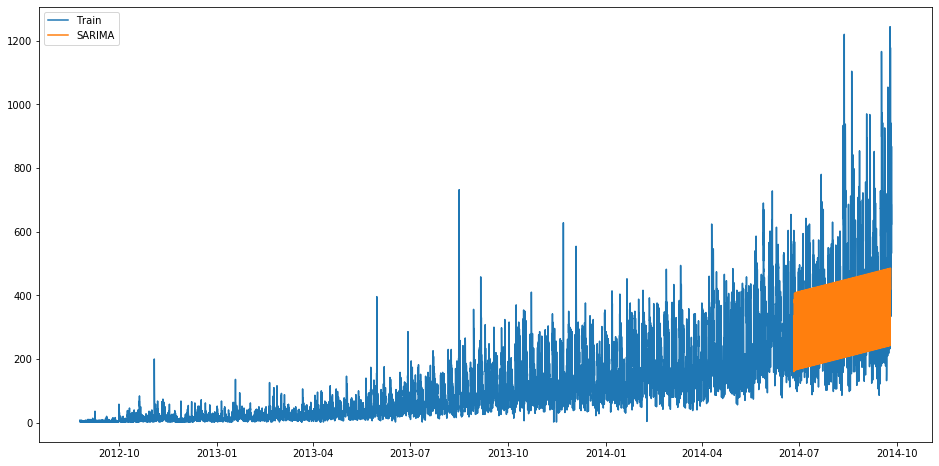

In [42]:
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train') 
plt.plot(pred, label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [57]:
rmse = np.sqrt(mean_squared_error(valid.Count,pred))

In [58]:
rmse

142.49567201432282

In [ ]:
submit=test_original
submit['Prediction']=pred.values
submit.index=submit.ID
submit.drop(['ID','Datetime','year','month','day','Hour'], axis=1, inplace=True)
submit.to_csv('submit.csv')
